# Convolutional neural network to determine emotion within text
The following notebook takes advantage of <b>supervised learning</b> to produce a <b>CNN</b> capable of predicting emotion within string input 
<br>
<br>
This dataset was downloaded from Kaggle and can be found via the following URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions

---

## Import the necessary Python modules

In [1]:
# Used for data visualization
import pandas as pd

# Used for model building and data preparation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Used in creating visualizations for CNN results
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Retrieve the data and perform some simple data cleaning

In [2]:
# Get the data from the csv file
twitter = pd.read_csv("text.csv")

# Drop the first column
twitter.drop(columns=twitter.columns[0], axis=1, inplace=True)

# Remove duplicated from the dataset
twitter.drop_duplicates()

twitter

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


label
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


Text(0, 0.5, '')

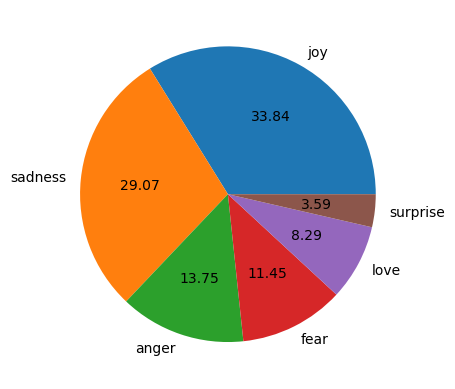

In [3]:
# Mapping between encoded categories and their string labels
mapping = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
labels_mapped = twitter['label'].map(mapping)

# Visualize the distribution of our category labels in the dataset 
print(labels_mapped.value_counts())
labels_mapped.value_counts().plot.pie(autopct='%.2f').set_ylabel('')

## Split the dataset into training and test
20% of the data is used for training

In [4]:
X_train, X_test, y_train, y_test = train_test_split(twitter['text'], twitter['label'], test_size=0.2)

## Tokenize the string data so that it's suitable as input for the CNN
Padding is added to help ensure all input sequences are of the same length

In [5]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=250)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=250)

## Build the sequential CNN model

In [6]:
cnn_model = Sequential()

# Embedding input layer that will accept the integer encoded input strings
cnn_model.add(Embedding(input_dim=10000, output_dim=16))

# One dimensional convulation layer that creates the convolution kernal
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Apply one dimensional max pooling over the input signal to help summarize the presence of features in the input data
cnn_model.add(GlobalMaxPooling1D())

# Two final dense layers with the final being an output layer with 6 neurons (one for each emotion category) 
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=6, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model we've created
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 179014 (699.27 KB)
Trainable params: 179014 (699.27 KB)
Non-trainable params: 0 (0.00 Byte)
______________

## Time to actually train this dang model!

In [7]:
# Use early stopping to stop training when parameter updates no longer yield improvements
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Begin the training on the CNN
history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=25, 
                             validation_data=(X_test_padded, y_test),
                             callbacks=[early_stopping])

Epoch 1/25


10421/10421 [==============================] - 62s 6ms/step - loss: 0.1899 - accuracy: 0.9104 - val_loss: 0.1263 - val_accuracy: 0.9283
Epoch 2/25
10421/10421 [==============================] - 61s 6ms/step - loss: 0.1122 - accuracy: 0.9336 - val_loss: 0.1127 - val_accuracy: 0.9330
Epoch 3/25
10421/10421 [==============================] - 62s 6ms/step - loss: 0.1026 - accuracy: 0.9369 - val_loss: 0.1115 - val_accuracy: 0.9317
Epoch 4/25
10421/10421 [==============================] - 59s 6ms/step - loss: 0.0963 - accuracy: 0.9391 - val_loss: 0.1136 - val_accuracy: 0.9334
Epoch 5/25
10421/10421 [==============================] - 60s 6ms/step - loss: 0.0926 - accuracy: 0.9397 - val_loss: 0.1148 - val_accuracy: 0.9310
Epoch 6/25
10421/10421 [==============================] - 64s 6ms/step - loss: 0.0892 - accuracy: 0.9419 - val_loss: 0.1175 - val_accuracy: 0.9316
Epoch 7/25
10421/10421 [==============================] - 63s 6ms/step - loss: 0.0874 - accuracy: 0.9424 - val_loss:

## Let's see how it did. First off, let's see the training and validation loss over the course of the model's training

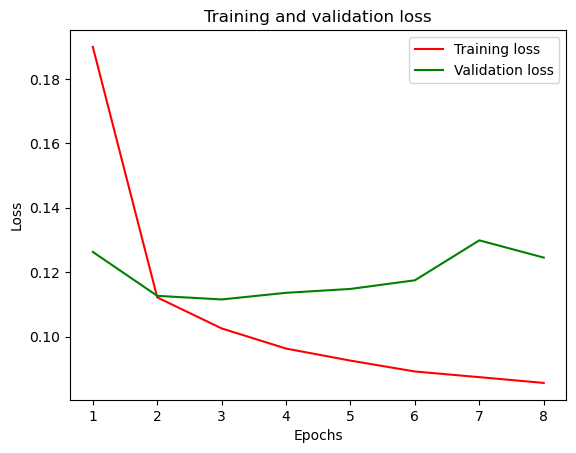

In [8]:
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Now let's create a confusion matrix to showcase the the CNN's ability to predict data it hasn't seen yet (X_test_padded)

2606/2606 [==============================] - 7s 3ms/step


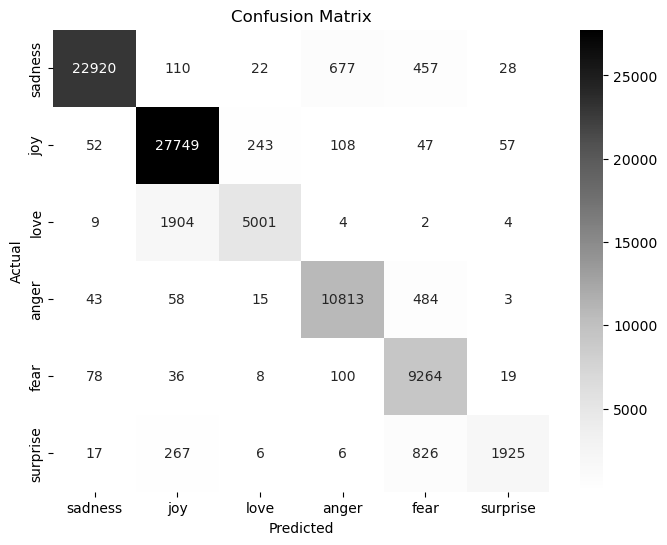

In [9]:
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)
conf_mat = confusion_matrix(y_test, y_pred)
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()